## 📊 Notebook 2: Análisis exploratorio de datos (EDA)
En esta notebook se lleva a cabo un análisis exploratorio de las reseñas procesadas. Se examina la distribución de calificaciones, la evolución temporal de los comentarios, patrones de longitud en los textos y otras variables relevantes. Este paso permite obtener una primera comprensión de la estructura de los datos y guiar futuras decisiones analíticas.


### 📥 Carga de datos procesados

En esta sección se carga el dataset previamente limpiado y unificado durante la etapa de preprocesamiento. El archivo incluye reseñas de productos (Samsung A15 y Motorola G32), junto con sus calificaciones, fechas y textos normalizados. Esto permitirá realizar un análisis exploratorio confiable sobre los patrones de opinión de los usuarios.

In [3]:
import pandas as pd

# Cargar datos limpios desde la etapa de preprocesamiento
df_total = pd.read_csv("../data/processed/reviews_unificado.csv", parse_dates=['date'])

# Vista general del DataFrame
df_total.info()
df_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   text          1083 non-null   object        
 1   rating        1085 non-null   int64         
 2   date          1085 non-null   datetime64[ns]
 3   useful_votes  1085 non-null   int64         
 4   producto      1085 non-null   object        
 5   text_clean    1083 non-null   object        
 6   text_length   1085 non-null   int64         
 7   year_month    1085 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 67.9+ KB


,text,rating,date,useful_votes,producto,text_clean,text_length,year_month
0,El celular es precioso! se lo regale a mi mamá...,5,2024-09-19,433,Samsung A15,el celular es precioso se lo regale a mi mama ...,114,2024-09
1,Súper lindo el celu muy recomendado.,5,2024-07-11,94,Samsung A15,super lindo el celu muy recomendado,6,2024-07
2,"Esta muy lindo. La cámara linda ,la batería du...",5,2024-08-26,94,Samsung A15,esta muy lindo la camara linda la bateria dura...,32,2024-08
3,"Realmente el producto me encantó,publico algun...",5,2024-10-22,72,Samsung A15,realmente el producto me encantopublico alguna...,119,2024-10
4,Desde que conocí samsung no deje de usar desde...,5,2024-10-07,52,Samsung A15,desde que conoci samsung no deje de usar desde...,54,2024-10


### 🗓️ Distribución temporal de las reseñas

Visualización de la cantidad de reseñas sa lo largo del tiempo. Esto permite detectar tendencias o picos de interés por los productos.

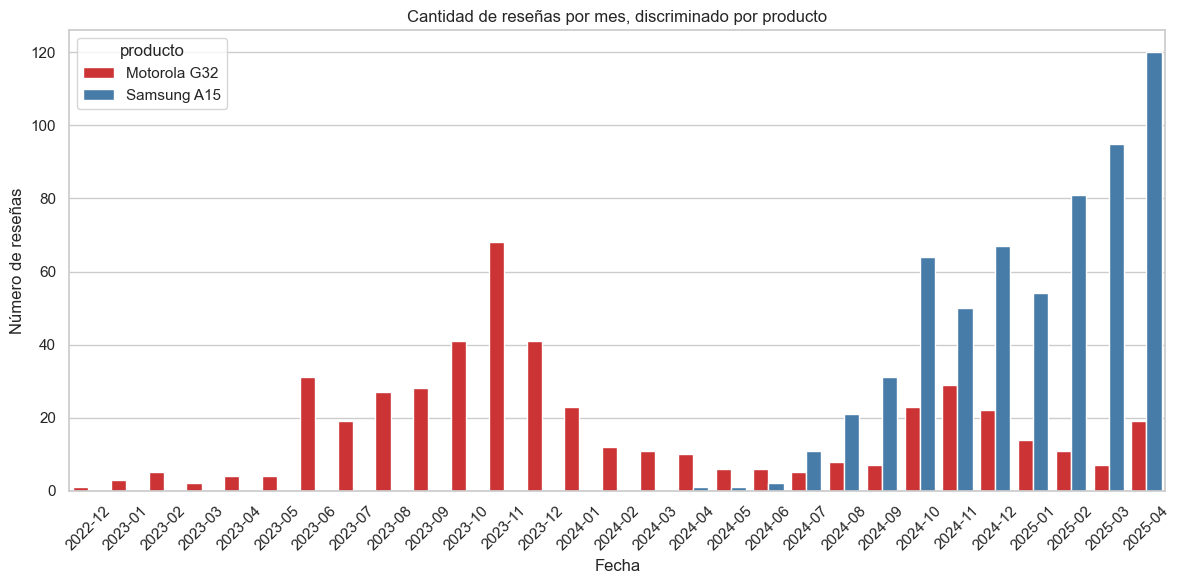

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_theme(style="whitegrid")

# Crear columna para año y mes
df_total['year_month'] = df_total['date'].dt.to_period('M')

# Agregar columna de producto
df_total['producto'] = df_total['producto'].astype('category')

# Conteo mensual por producto
reviews_by_month_product = df_total.groupby(['year_month', 'producto'], observed=False).size().reset_index(name='count')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='year_month', y='count', hue='producto', data=reviews_by_month_product, palette='Set1')
plt.title("Cantidad de reseñas por mes, discriminado por producto")
plt.xlabel("Fecha")
plt.ylabel("Número de reseñas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 📊 Proporción de ratings por producto

Este gráfico de barras muestra la distribución relativa de calificaciones (ratings) dentro de cada producto. A diferencia de los conteos absolutos, aquí cada barra representa la proporción de reseñas con determinado puntaje sobre el total de reseñas de ese producto, lo cual permite una comparación más justa entre productos con diferente volumen de opiniones.

/var/folders/xj/bjstjydx13sdd594_hv58l2w0000gn/T/ipykernel_39124/378716767.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('producto')['rating']


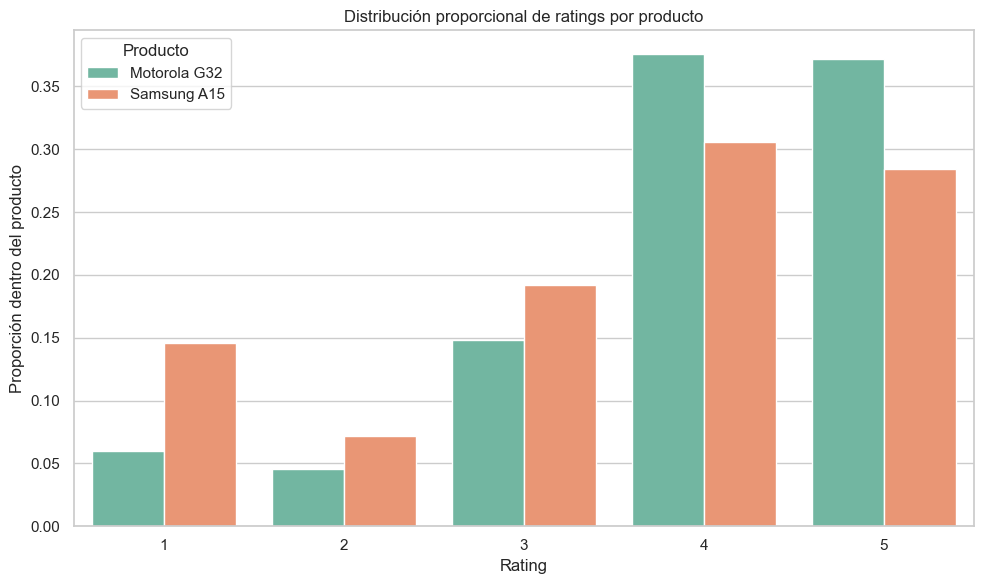

In [15]:
# Calcular proporciones de ratings por producto
rating_proportions = (
    df_total
    .groupby('producto')['rating']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
)

# Estilo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Gráfico
sns.barplot(
    data=rating_proportions,
    x='rating',
    y='proportion',
    hue='producto',
    palette='Set2'
)

plt.title("Distribución proporcional de ratings por producto")
plt.xlabel("Rating")
plt.ylabel("Proporción dentro del producto")
plt.legend(title='Producto')
plt.tight_layout()
plt.show()


### 📊 Distribución de longitud de reseñas por producto

Este gráfico muestra la distribución de la longitud de las reseñas, medida en cantidad de palabras, diferenciando entre los dos productos. Nos permite observar si los usuarios tienden a escribir comentarios más extensos para un producto que para otro.


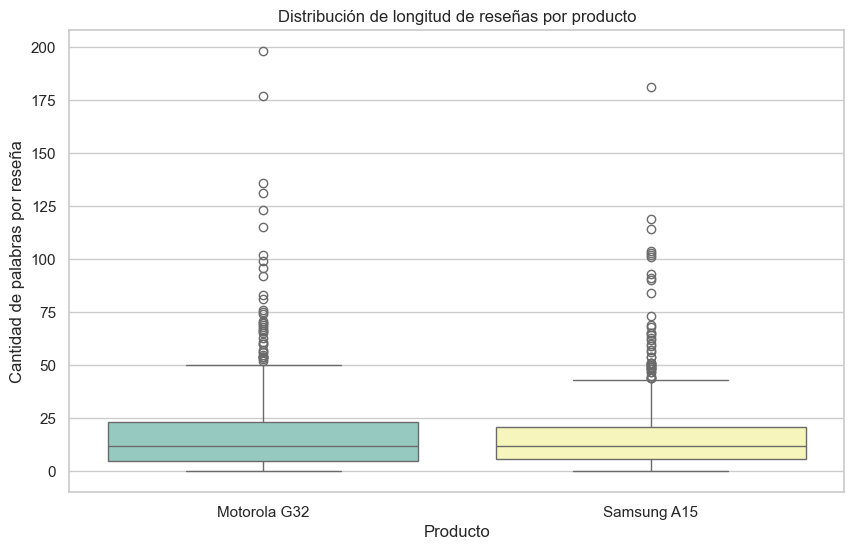

In [23]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_total, x='producto', y='text_length', hue='producto', palette='Set3', legend=False)
plt.title("Distribución de longitud de reseñas por producto")
plt.xlabel("Producto")
plt.ylabel("Cantidad de palabras por reseña")
plt.show()

### 📊 Evolución de la longitud promedio en el tiempo

Este gráfico muestra cómo varía la extensión de las reseñas a lo largo del tiempo para cada producto. Se calcula el promedio mensual de la cantidad de palabras (columna `text_length`) y se representa mediante una línea por producto. Esto permite detectar posibles cambios en el comportamiento de los usuarios, como una mayor elaboración de opiniones en ciertos períodos, o bien transformaciones en el perfil del comprador o en las campañas de venta.


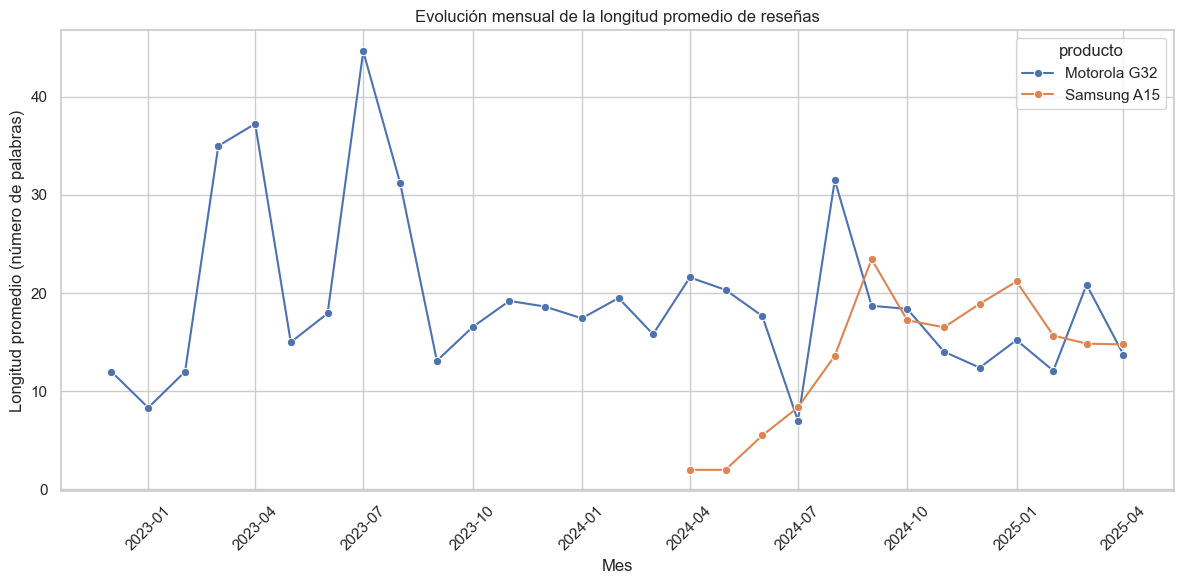

In [27]:
# Agrupamos por mes y producto, usando la columna 'date' (datetime)
longitud_mensual = (
    df_total
    .assign(month=pd.to_datetime(df_total['date'].dt.to_period('M').astype(str)))  # mes como datetime
    .groupby(['month', 'producto'], observed=True)['text_length']
    .mean()
    .reset_index()
)

# Gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(data=longitud_mensual, x='month', y='text_length', hue='producto', marker='o')
plt.title("Evolución mensual de la longitud promedio de reseñas")
plt.xlabel("Mes")
plt.ylabel("Longitud promedio (número de palabras)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



### 📊 Distribución de calificaciones a lo largo del tiempo

Este gráfico muestra la evolución mensual de la calificación promedio otorgada por los usuarios para cada producto. Permite identificar posibles tendencias en la percepción del producto, como mejoras o deterioros en la experiencia de uso reportada. También puede reflejar cambios en el tipo de comprador o en las expectativas a lo largo del tiempo.

- Se calcula el promedio de `rating` por mes (`date` agregada a nivel de `month`) y por producto.
- Las líneas permiten visualizar comparativamente cómo se comporta la valoración de cada producto en el tiempo.
- El eje Y está restringido entre 1 y 5, que son los valores posibles de calificación en la plataforma.


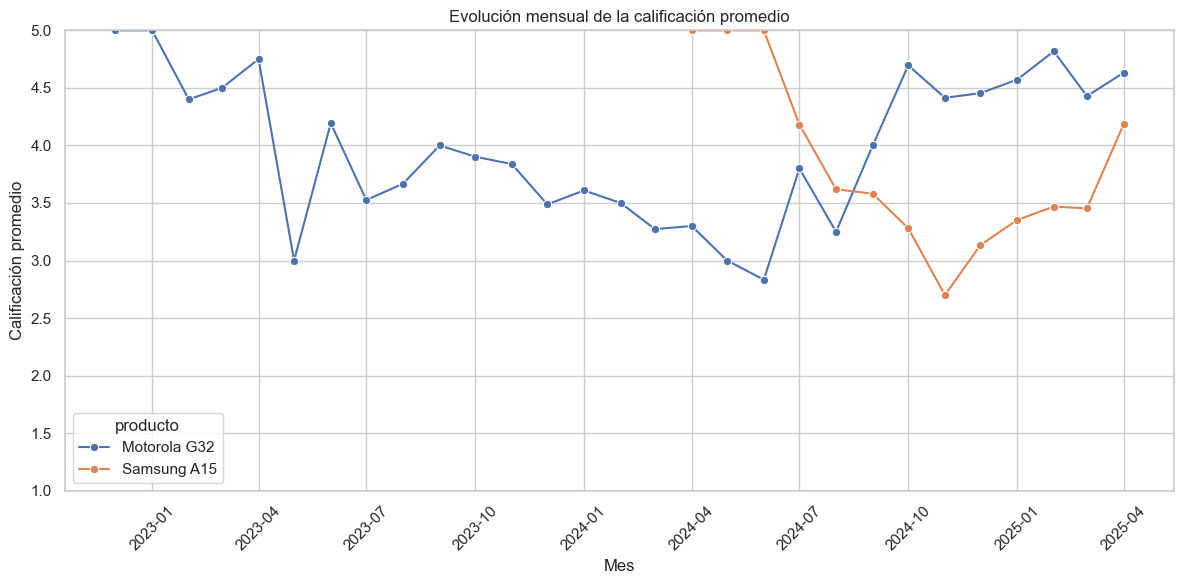

In [28]:
# Agrupación por mes y producto para calificaciones promedio
calificacion_mensual = (
    df_total
    .assign(month=pd.to_datetime(df_total['date'].dt.to_period('M').astype(str)))
    .groupby(['month', 'producto'], observed=True)['rating']
    .mean()
    .reset_index()
)

# Gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(data=calificacion_mensual, x='month', y='rating', hue='producto', marker='o')
plt.title("Evolución mensual de la calificación promedio")
plt.xlabel("Mes")
plt.ylabel("Calificación promedio")
plt.xticks(rotation=45)
plt.ylim(1, 5)
plt.tight_layout()
plt.show()


### 📊 Distribución de calificaciones por cantidad de palabras

Este gráfico explora la relación entre la longitud del texto (en cantidad de palabras) y la calificación otorgada. Utiliza un boxplot para observar si existen patrones en cómo las personas puntúan en función del nivel de detalle que ofrecen en sus reseñas. Por ejemplo, si las reseñas más extensas tienden a tener calificaciones más bajas o más altas, o si las más breves se concentran en los extremos del rango de puntuación.

Este análisis permite evaluar si hay una conexión entre el esfuerzo que implica redactar una reseña y la emocionalidad (positiva o negativa) del mensaje.


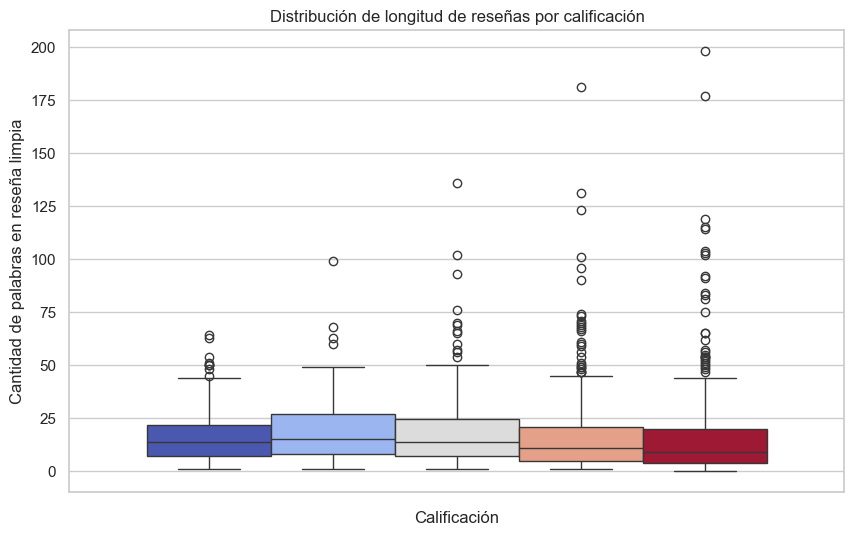

In [43]:
# Configurar estilo
sns.set_theme(style="whitegrid")

# Crear el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_total, hue='rating', y='text_length', palette='coolwarm', legend=False)

# Títulos y etiquetas
plt.title("Distribución de longitud de reseñas por calificación")
plt.xlabel("Calificación")
plt.ylabel("Cantidad de palabras en reseña limpia")
plt.show()

### 📊 Evolución mensual de la longitud promedio de reseñas

Este gráfico muestra cómo varía la extensión promedio de las reseñas a lo largo del tiempo para cada producto. Puede ayudar a identificar tendencias como un mayor nivel de detalle en las opiniones o posibles cambios en la experiencia del usuario.

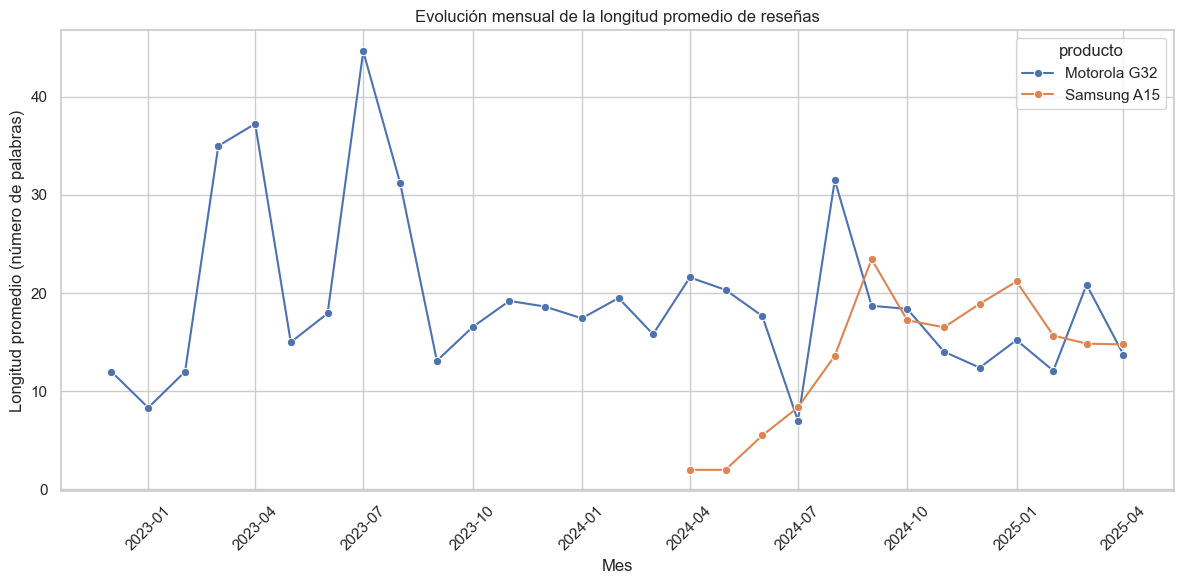

In [ ]:
# Agrupamos por mes y producto, usando la columna 'date' (datetime)
longitud_mensual = (
    df_total
    .assign(month=pd.to_datetime(df_total['date'].dt.to_period('M').astype(str)))  # mes como datetime
    .groupby(['month', 'producto'], observed=True)['text_length']
    .mean()
    .reset_index()
)

# Gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(data=longitud_mensual, x='month', y='text_length', hue='producto', marker='o')
plt.title("Evolución mensual de la longitud promedio de reseñas")
plt.xlabel("Mes")
plt.ylabel("Longitud promedio (número de palabras)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



## Análisis exploratorio avanzado de comportamiento de reseñas

Complementando el análisis descriptivo previo, se incorporan visualizaciones avanzadas que permiten observar patrones de comportamiento, desgaste reputacional y dinámica de volumen de reseñas para los productos **Motorola G32** y **Samsung A15**.

Estas visualizaciones aportan una capa adicional de interpretación, especialmente útil para mostrar en portafolios profesionales la capacidad de llevar el análisis exploratorio hacia dimensiones más narrativas y de diagnóstico.


### Balance mensual de ratings positivos (4-5) vs negativos (1-2)
Este gráfico apilado permite visualizar mes a mes la proporción relativa de reseñas positivas frente a negativas dentro del volumen total del producto. Resulta útil para identificar ciclos de saturación reputacional o momentos críticos.

<Figure size 1400x700 with 0 Axes>

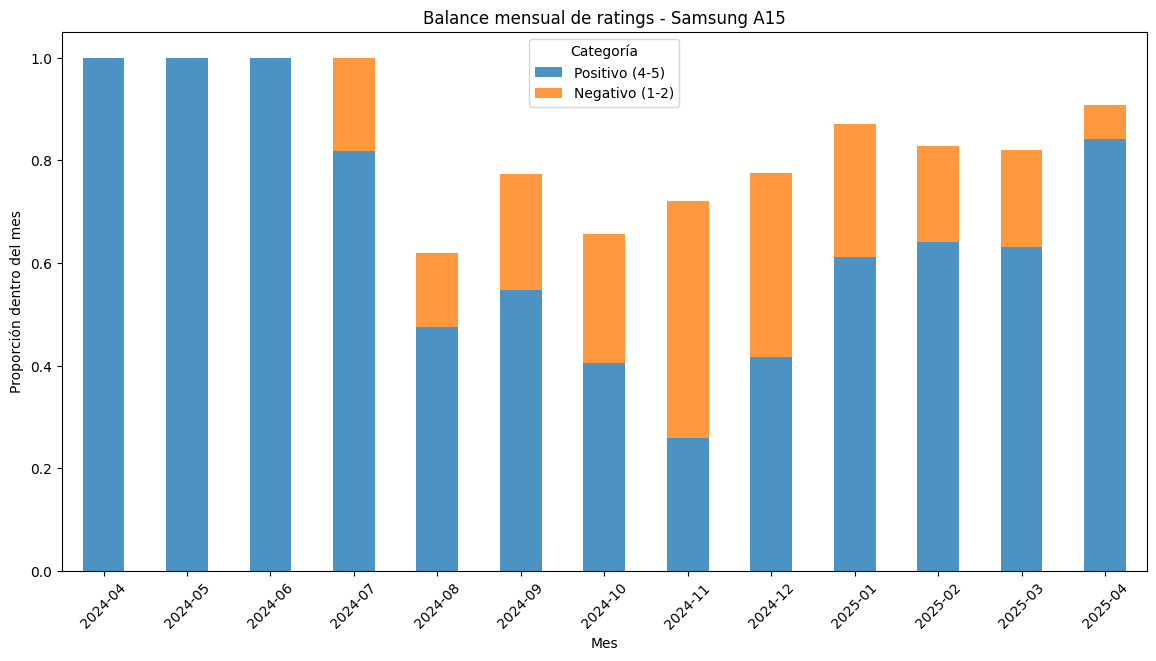

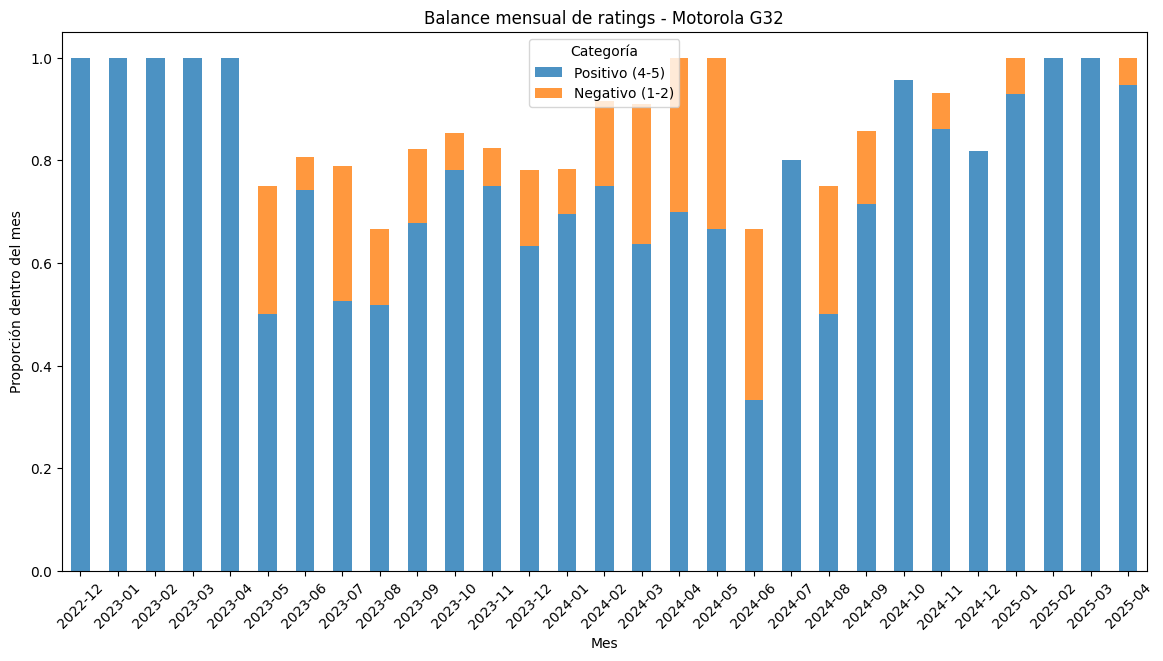

In [4]:
# Crear columna de categoría de rating
df_total['Categoria_Rating'] = df_total['rating'].apply(lambda x: 'Positivo (4-5)' if x >= 4 else ('Negativo (1-2)' if x <= 2 else 'Neutral (3)'))

# Crear columna mes_año
df_total['mes_año'] = df_total['date'].dt.to_period('M').astype(str)

# Agrupar por producto, mes y categoría
df_balance = df_total.groupby(['producto', 'mes_año', 'Categoria_Rating']).size().reset_index(name='conteo')
df_total_mes = df_total.groupby(['producto', 'mes_año']).size().reset_index(name='total')
df_balance = df_balance.merge(df_total_mes, on=['producto', 'mes_año'])
df_balance['proporcion'] = df_balance['conteo'] / df_balance['total']

# Gráfico stacked
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for producto in df_total['producto'].unique():
    df_p = df_balance[df_balance['producto'] == producto]
    df_pivot = df_p.pivot(index='mes_año', columns='Categoria_Rating', values='proporcion').fillna(0)
    df_pivot[['Positivo (4-5)', 'Negativo (1-2)']].plot(kind='bar', stacked=True, alpha=0.8, title=f"Balance mensual de ratings - {producto}", figsize=(14, 7))
    plt.ylabel('Proporción dentro del mes')
    plt.xlabel('Mes')
    plt.xticks(rotation=45)
    plt.legend(title='Categoría')
    plt.show()



### Curva acumulativa de reseñas por producto
La curva acumulativa permite analizar el ritmo de adopción y el ciclo de vida de las reseñas, reflejando la evolución de la presencia del producto en el mercado digital.



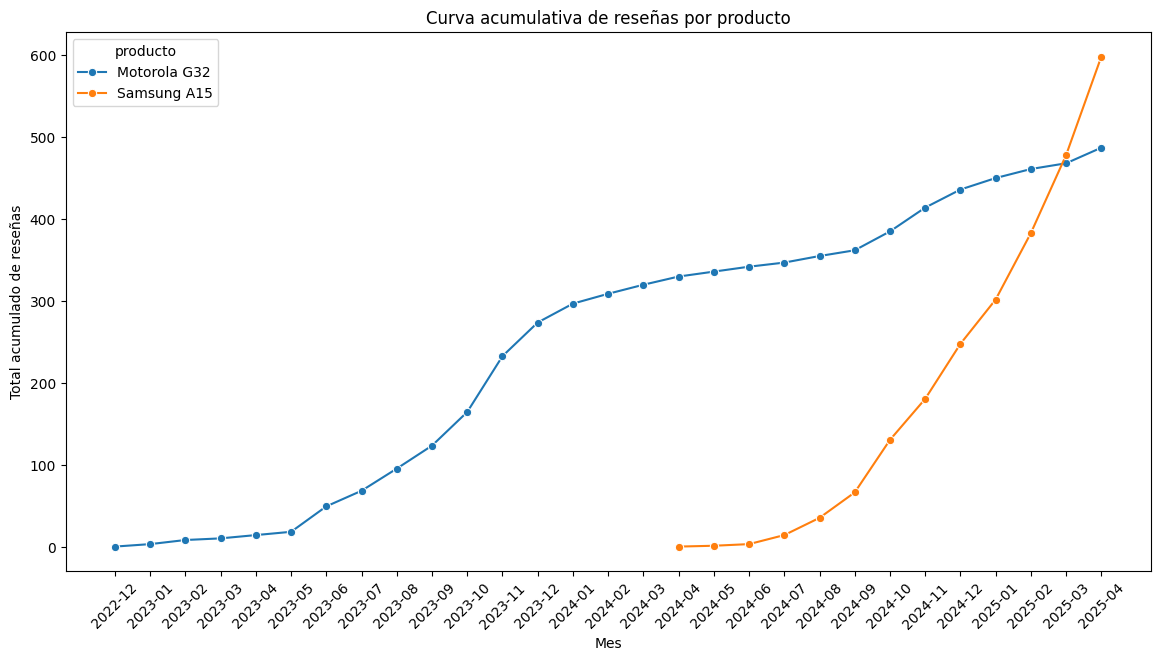

In [5]:
df_cumulative = df_total.groupby(['producto', 'mes_año']).size().groupby(level=0).cumsum().reset_index(name='acumuladas')

plt.figure(figsize=(14, 7))
import seaborn as sns

sns.lineplot(data=df_cumulative, x='mes_año', y='acumuladas', hue='producto', marker='o')
plt.title('Curva acumulativa de reseñas por producto')
plt.ylabel('Total acumulado de reseñas')
plt.xlabel('Mes')
plt.xticks(rotation=45)
plt.show()

### Dispersión de ratings individuales por fecha
El gráfico de dispersión permite observar la evolución granular de los ratings, identificando posibles picos de insatisfacción o patrones atípicos.


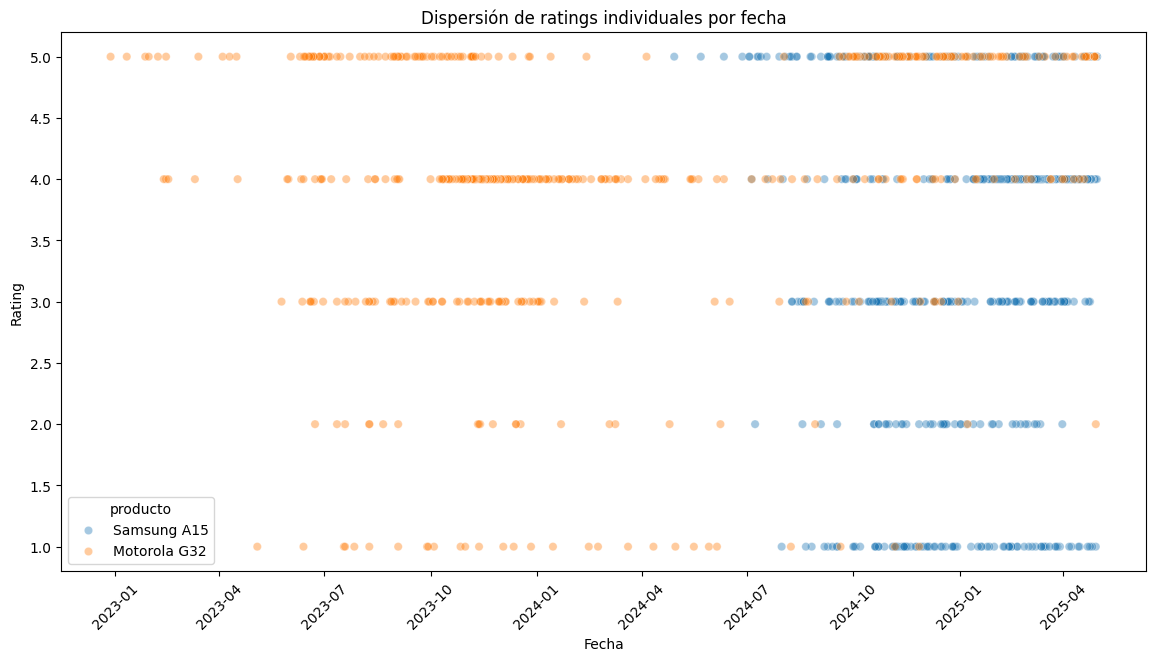

In [6]:
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_total, x='date', y='rating', hue='producto', alpha=0.4)
plt.title('Dispersión de ratings individuales por fecha')
plt.ylabel('Rating')
plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.show()


### Boxplot mensual de longitud de reseñas
El boxplot de longitud permite visualizar la variabilidad y profundidad de las reseñas a lo largo del tiempo, destacando momentos donde se generan comen
tarios más elaborados y críticos.


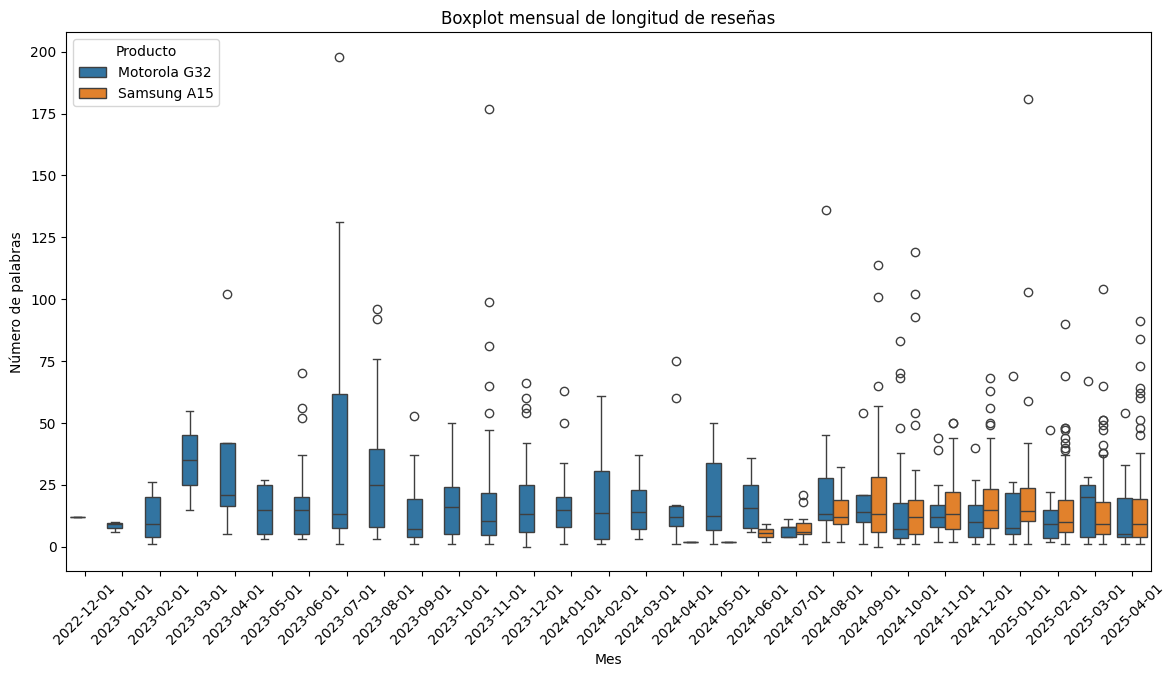

In [11]:
df_total['year_month'] = pd.to_datetime(df_total['year_month'], format='%Y-%m')
df_total = df_total.sort_values('year_month')

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_total, x='year_month', y='text_length', hue='producto')
plt.title('Boxplot mensual de longitud de reseñas')
plt.ylabel('Número de palabras')
plt.xlabel('Mes')
plt.xticks(rotation=45)
plt.legend(title='Producto')
plt.show()

### 📊 Distribución de votos útiles en las reseñas

La mayoría de las reseñas tienen **0 votos útiles**, y solo unas pocas concentran valores muy altos (hasta 617). Esto genera una distribución extremadamente sesgada a la izquierda. Para visualizar mejor esta situación, limitamos el histograma a reseñas con un máximo de 30 votos útiles, lo que abarca al 93% de los casos.


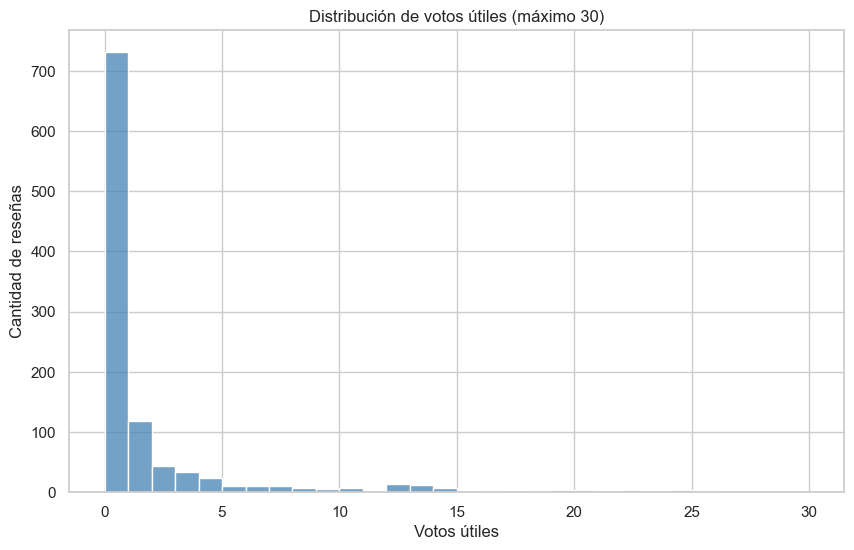

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(df_total[df_total['useful_votes'] <= 30]['useful_votes'], 
             bins=30, color='steelblue')
plt.title("Distribución de votos útiles (máximo 30)")
plt.xlabel("Votos útiles")
plt.ylabel("Cantidad de reseñas")
plt.show()


### 📊 Relación entre la longitud de la reseña y los votos útiles

Este gráfico de dispersión muestra cómo se distribuyen los votos útiles en función de la cantidad de palabras de cada reseña. Se observa que las reseñas más largas tienden a recibir más votos útiles, aunque también hay muchas reseñas extensas con pocos votos. La relación parece ser débil pero sugiere que los usuarios valoran más las reseñas detalladas.

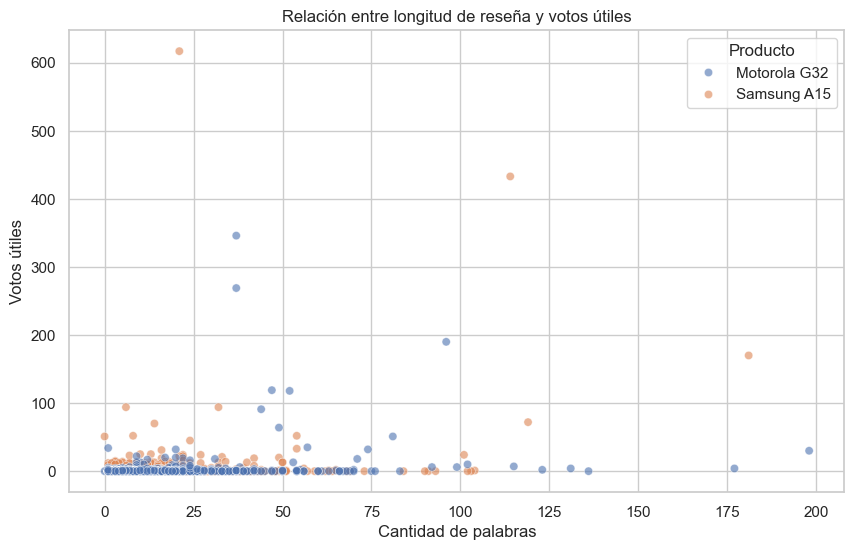

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_total, x='text_length', y='useful_votes', hue='producto', alpha=0.6)
plt.title("Relación entre longitud de reseña y votos útiles")
plt.xlabel("Cantidad de palabras")
plt.ylabel("Votos útiles")
plt.legend(title="Producto")
plt.show()


### 📊 Votos útiles según calificación otorgada

Este boxplot permite observar cómo varía la cantidad de votos útiles que recibe una reseña en función de la calificación que otorgó el usuario. Aunque la mayoría de las reseñas con cualquier calificación reciben pocos votos útiles (como lo indica la mediana), se nota una mayor dispersión en calificaciones intermedias (por ejemplo, 3 y 4 estrellas), lo que podría indicar que reseñas con matices o críticas más elaboradas tienden a ser más valoradas por otros usuarios.


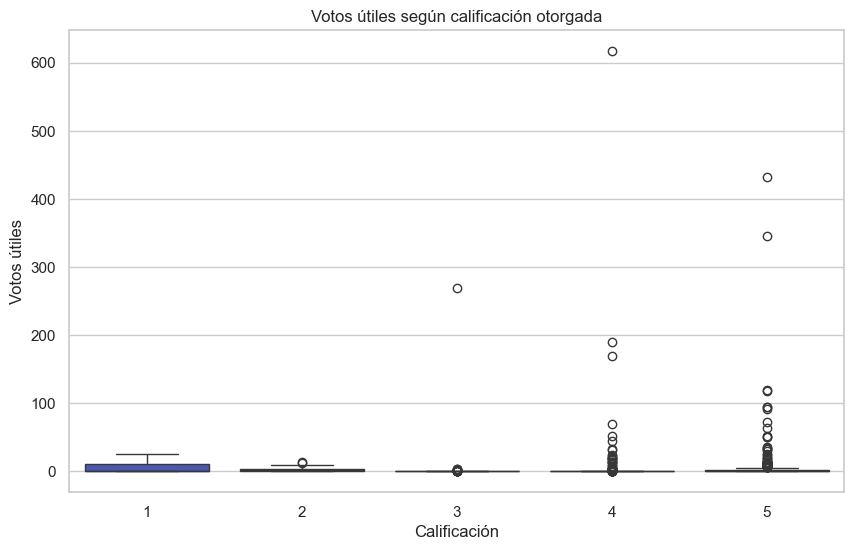

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_total, x='rating', y='useful_votes', hue='rating', palette='coolwarm', legend=False)
plt.title("Votos útiles según calificación otorgada")
plt.xlabel("Calificación")
plt.ylabel("Votos útiles")
plt.show()
